# CAMP II Surgical Workflow Analysis Exercise

It is highly recommended to complete the CAMP II Exercises on Classification and Segmentation before this one!  
Feel free to reuse code you wrote for these other exercises here, it might be useful. Make sure to activate the GPU in colab before you start this exercise.

In this exercise, we will be making first steps towards workflow analysis from endoscopic data. Specifically, we will be extracting the surgical phases, such as "Preparation" or "ColotTriangleDissection". 

We will be working with an extended version of the dataset used in the exercise classification and segmentation. The extension allows us to observe the full workflow steps in every video.

This notebook has many codeblocks already in place to help you get started. Places where you have to add your own code are clearly marked with "TASK" and lines ("-----"). When a variable you have to implement is used later on, we placed a name and description in the task bracket (see example below). These markings are only there to guide you toward what you have to implement to complete the exercise, feel free to experiment beyond them.






In [ ]:
# TASK: description of the task you need to do ---------------------------------
# my_variable_name: a variable that is used later on, so the name should be right

# ------------------------------------------------------------------------------

When looking for solutions to the tasks below, definitely consider online resources such as the ones linked below:

Pytorch (torch) documentation: <br>
https://pytorch.org/docs/stable/index.html

Pytorch Vision (torchvision) documentation: <br>
https://pytorch.org/vision/stable/index.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download the dataset to your notebook
# if you get access denied, retry after a minute
# !gdown 1MwtcHceqj8FchmsIR92pRb0tR-QZ9uh4
!unzip -qq '/content/drive/MyDrive/camp/liver_endoscopy_dataset_workflow.zip' 
!rm liver_endoscopy_dataset_workflow.zip
# this block should take 1 min

rm: cannot remove 'liver_endoscopy_dataset_workflow.zip': No such file or directory


In [3]:
!pip -qq install pytorch_lightning==1.6.2

     |████████████████████████████████| 582 kB 4.9 MB/s 
     |████████████████████████████████| 418 kB 59.3 MB/s 
     |████████████████████████████████| 140 kB 72.4 MB/s 
     |████████████████████████████████| 596 kB 62.7 MB/s 
     |████████████████████████████████| 1.1 MB 63.6 MB/s 
     |████████████████████████████████| 144 kB 71.5 MB/s 
     |████████████████████████████████| 271 kB 66.3 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 


We import the libraries that will be useful

In [4]:
import json
import random
from collections import defaultdict
from pathlib import Path
from typing import Optional

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchvision
from PIL import Image
from sklearn.metrics import classification_report
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap

## 0. Dataset
We load the liver endoscopy dataset here. This cell defines the video splits, correctly loads the dataset depending on the task.

In [5]:
video_splits = {'train': ['01', '02', '05', '13', '15', '18', '22'], 'val': ['08', '29', '50'], 'test': ['06', '10', '42']}


class LiverEndoscopy(Dataset):
    def __init__(self, split: str = 'train', balance_data: bool = False, temporal: bool = False,
                 pil_transform: Optional[transforms.Compose] = None, tensor_transform: Optional[transforms.Compose] = None, augmentation=None):
        assert split in ['train', 'val', 'test']
        self.split = split
        self.balance_data = balance_data
        self.temporal = temporal
        self.pil_transform = pil_transform
        self.tensor_transform = tensor_transform
        self.augmentation = augmentation

        self.phases_to_indices = {'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4,
                                  'CleaningCoagulation': 5, 'GallbladderRetraction': 6}
        self.indices_to_phases = {value: key for key, value in self.phases_to_indices.items()}

        export_dataset_path = Path('data_workflow')
        self.images_path = export_dataset_path / 'images'
        with open(export_dataset_path / 'phase_annotations.json', 'r') as f:
            self.workflow_phase_annotations = json.load(f)

        if not temporal:
            self.image_names = []
            for image_path in sorted(self.images_path.glob('*.png')):
                video_id = image_path.name.split('_')[0].replace('video', '')
                if video_id in video_splits[split]:
                    self.image_names.append(image_path.name.replace('.png', ''))
            self.image_names = sorted(self.image_names)

        else:
            self.window_size = 8
            self.downsample_factor = 25
            all_image_names = sorted(self.images_path.glob('*.png'))
            all_video_ids = {image_name.name.split('_')[0].replace('video', '') for image_name in all_image_names}
            all_split_video_ids = {video_id for video_id in all_video_ids if video_id in video_splits[split]}
            self.windows = []
            for video_id in all_split_video_ids:
                sequence_images = sorted(self.images_path.glob(f'video{video_id}_*.png'))
                sequence_image_indices = [int(image_name.name.split('_')[1].replace('.png', '')) for image_name in sequence_images]
                for i in range(len(sequence_images) - self.window_size + 1):
                    self.windows.append((video_id, sequence_image_indices[i:i + self.window_size]))

        if balance_data:
            self.do_balance_data(temporal)

    def do_balance_data(self, temporal):
        print('Balancing data by oversampling under-represented classes...')
        class_to_samples = defaultdict(list)
        if not temporal:
            for image_name in self.image_names:
                label = self.workflow_phase_annotations[image_name]
                class_to_samples[label].append(image_name)
            max_number = max([len(elem) for elem in class_to_samples.values()])
            self.image_names = []
            for key, value in class_to_samples.items():
                if len(value) < max_number:
                    self.image_names += random.choices(value, k=max_number)
                else:
                    self.image_names += value
            random.shuffle(self.image_names)
        else:
            for video_id, window in self.windows:
                label = self.workflow_phase_annotations[f'video{video_id}_{str(window[-1]).zfill(6)}']
                class_to_samples[label].append((video_id, window))
            max_number = max([len(elem) for elem in class_to_samples.values()])
            self.windows = []
            for key, value in class_to_samples.items():
                if len(value) < max_number:
                    self.windows += random.choices(value, k=max_number)
                else:
                    self.windows += value
            random.shuffle(self.windows)

    def __len__(self):
        if self.temporal:
            return len(self.windows)
        else:
            return len(self.image_names)

    def phase_label_to_number(self, phase_label):
        return self.phases_to_indices[phase_label]

    def number_to_phase_label(self, phase_number):
        return self.indices_to_phases[phase_number]

    def __getitem__(self, index):
        if self.temporal:
            video_id, window = self.windows[index]
            image_names = []
            for frame_number in window:
                image_names.append(f'video{video_id}_{str(frame_number).zfill(6)}.png')

            phase = self.phase_label_to_number(self.workflow_phase_annotations[image_names[-1].replace('.png', '')])
            return {'image_names': image_names, 'phase': phase}
        else:
            image_name = self.image_names[index]
            image_path = self.images_path / f'{image_name}.png'
            image = Image.open(image_path)
            if self.pil_transform is not None:
                image = self.pil_transform(image)
            if self.augmentation is not None:
                image = self.augmentation(image)
            image_tensor = transforms.ToTensor()(image)
            if self.tensor_transform is not None:
                image_tensor = self.tensor_transform(image_tensor)

            phase = self.phase_label_to_number(self.workflow_phase_annotations[image_name])

            return {'image': image_tensor, 'phase': phase, 'image_name': image_name}


## A. Workflow Recognition without Temporal Modelling

First, we will try to recognize the different phases of the surgical workflow from each frame of the video. This is equivalent to a multi-class classification problem on each frame.

### A.1 Load the data as images with phase labels


In [69]:
# Fix pytorch_lightning seed
pl.seed_everything(42)

# load data
pil_transform = transforms.Compose([transforms.Resize((224, 224))])
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=.1, hue=.1),
                                    transforms.RandomRotation(degrees=(0, 30)),
                                    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0))])

train_dataset = LiverEndoscopy(split='train', balance_data=False, temporal=False, pil_transform=None, augmentation=augmentation)
val_dataset = LiverEndoscopy(split='val', balance_data=False, temporal=False, pil_transform=pil_transform)
test_dataset = LiverEndoscopy(split='test', balance_data=False, temporal=False, pil_transform=pil_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Global seed set to 42


#### Explore the data

The phase of the image is 1


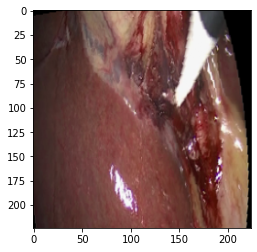

In [70]:
# TASK: Load a random sample from the dataset, visualize the image and its phase label

import random

n=random.randint(0,len(train_dataset))
data = train_dataset[n]

image = data['image']
phase = data['phase']

plt.imshow(image.permute(1, 2, 0))

print('The phase of the image is', phase)

# ------------------------------------------------------------------------------

### A.2 Load and train a workflow recognition model
We already provide most of the code skeleton in this part. To finish this model, you will need to make the following modifications.
1. An image processing model (resnet18, pretrained=True), which you can find in torchvision.
2. Disable the final layer (fc) of the image model
3. Define a new linear layer, that takes as input the output of the image model, and outputs 7 nodes. These will correspond to the 7 classes.
4. Define the forward function, which uses the image model and the linear layer
5. Complete the training, validation and test steps, where the models forward function is called to get a prediction, and then a cross entropy loss between the correct phase and the prediction is computed. Tip: F.cross_entropy()


In [71]:
class ModelWrapper(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # TASK: define image model, disable final layer, add linear layer ------

        self.image_backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.image_backbone.fc =  nn.Linear(512,7)

        # ----------------------------------------------------------------------       

        self.train_preds = []
        self.train_gts = []
        self.val_preds = []
        self.val_gts = []
        self.test_preds = []
        self.test_gts = []
        self.reset_metrics()

        self.train_loss = []
        self.val_loss = []
        self.test_loss = []

        self.phase_names = ['Preparation', 'ColotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation',
                            'GallbladderRetraction']

    def forward(self, x):
        #TASK use the image model and linear layer to get a prediction ---------

        x = self.image_backbone(x)

        # ----------------------------------------------------------------------
        return x

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        x = batch['image']
        y = batch['phase']
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat,y)

        # ----------------------------------------------------------------------       
        self.update_metrics(batch['phase'], y_hat, split='train')
        self.train_loss.append(loss.item())
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        x = batch['image']
        y = batch['phase']
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat,y)

        # ----------------------------------------------------------------------
        self.update_metrics(batch['phase'], y_hat, split='val')
        self.val_loss.append(loss.item())
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        x = batch['image']
        y = batch['phase']
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat,y)
        
        # ----------------------------------------------------------------------
        self.update_metrics(batch['phase'], y_hat, split='test')
        self.test_loss.append(loss.item())
        return {'test_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

    def reset_metrics(self, split=None):
        if split == 'train':
            self.train_preds = []
            self.train_gts = []
        elif split == 'val':
            self.val_preds = []
            self.val_gts = []
        elif split == 'test':
            self.test_preds = []
            self.test_gts = []
        else:
            self.train_preds = []
            self.train_gts = []
            self.val_preds = []
            self.val_gts = []
            self.test_preds = []
            self.test_gts = []

    def update_metrics(self, gt, pred, split='train'):
        if split == 'train':
            self.train_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.train_gts.extend(gt.detach().cpu().numpy())
        elif split == 'val':
            self.val_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.val_gts.extend(gt.detach().cpu().numpy())
        elif split == 'test':
            self.test_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.test_gts.extend(gt.detach().cpu().numpy())
        else:
            raise NotImplementedError()

    def training_epoch_end(self, outputs):
        self.evaluate_predictions(split='train')
        self.reset_metrics(split='train')

    def validation_epoch_end(self, outputs):
        self.evaluate_predictions(split='val')
        self.reset_metrics(split='val')
    
    def test_epoch_end(self, outputs):
        self.evaluate_predictions(split='test')
        self.reset_metrics(split='test')

    def evaluate_predictions(self, split):
        if split == 'train':
            preds = self.train_preds
            gts = self.train_gts
        elif split == 'val':
            preds = self.val_preds
            gts = self.val_gts
        elif split == 'test':
            preds = self.test_preds
            gts = self.test_gts
        else:
            raise NotImplementedError()

        cls_report = classification_report(gts, preds, labels=list(range(len(self.phase_names))),
                                           target_names=self.phase_names)
        print(split)
        print(cls_report)

#### Create the model

In [72]:
# TASK: create the model -------------------------------------------------------
# model: your model

model = ModelWrapper()

# ------------------------------------------------------------------------------

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


#### Train the model

In [73]:
# TASK: train the model --------------------------------------------------------
# TIP: use pl.Trainer, make sure to use the gpu and train for 4 epochs, -> max_epochs=4. Make sure to call the fit function with both the train and validation loaders to get correct evaluations during training
# TIP: Training should take around 10 mins

# trainer: your trainer

!mkdir '/content/lightning_logs'

trainer = pl.Trainer(gpus=1, 
                    # precision=16, 
                    # check_val_every_n_epoch=1,
                    log_every_n_steps=5,
                     max_epochs=4
                     )

# Train!
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


# ------------------------------------------------------------------------------

mkdir: cannot create directory ‘/content/lightning_logs’: File exists


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | image_backbone | ResNet | 11.2 M
------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.00      0.00      0.00      64.0
ColotTriangleDissection       0.00      0.00      0.00       0.0
        ClippingCutting       0.00      0.00      0.00       0.0
  GallbladderDissection       0.00      0.00      0.00       0.0
   GallbladderPackaging       0.00      0.00      0.00       0.0
    CleaningCoagulation       0.00      0.00      0.00       0.0
  GallbladderRetraction       0.00      0.00      0.00       0.0

              micro avg       0.00      0.00      0.00      64.0
              macro avg       0.00      0.00      0.00      64.0
           weighted avg       0.00      0.00      0.00      64.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.17      0.15      0.16       164
ColotTriangleDissection       0.75      0.61      0.67      1747
        ClippingCutting       0.21      0.33      0.26       305
  GallbladderDissection       0.63      0.86      0.73      1669
   GallbladderPackaging       0.48      0.40      0.44       251
    CleaningCoagulation       0.69      0.04      0.07       563
  GallbladderRetraction       0.40      0.60      0.48       264

               accuracy                           0.59      4963
              macro avg       0.48      0.43      0.40      4963
           weighted avg       0.62      0.59      0.56      4963

train
                         precision    recall  f1-score   support

            Preparation       0.48      0.19      0.27       736
ColotTriangleDissection       0.69      0.74      0.71      4261
        ClippingCutting       0.69      0.36      0.47      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.16      0.19      0.17       164
ColotTriangleDissection       0.81      0.61      0.70      1747
        ClippingCutting       0.24      0.44      0.31       305
  GallbladderDissection       0.67      0.87      0.76      1669
   GallbladderPackaging       0.42      0.48      0.45       251
    CleaningCoagulation       0.75      0.10      0.18       563
  GallbladderRetraction       0.42      0.57      0.48       264

               accuracy                           0.61      4963
              macro avg       0.50      0.47      0.44      4963
           weighted avg       0.66      0.61      0.59      4963

train
                         precision    recall  f1-score   support

            Preparation       0.71      0.50      0.59       736
ColotTriangleDissection       0.87      0.90      0.88      4261
        ClippingCutting       0.82      0.77      0.80      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.08      0.16      0.11       164
ColotTriangleDissection       0.77      0.71      0.74      1747
        ClippingCutting       0.27      0.47      0.35       305
  GallbladderDissection       0.78      0.80      0.79      1669
   GallbladderPackaging       0.40      0.49      0.44       251
    CleaningCoagulation       0.79      0.13      0.22       563
  GallbladderRetraction       0.42      0.64      0.51       264

               accuracy                           0.62      4963
              macro avg       0.50      0.49      0.45      4963
           weighted avg       0.69      0.62      0.62      4963

train
                         precision    recall  f1-score   support

            Preparation       0.78      0.69      0.73       736
ColotTriangleDissection       0.91      0.93      0.92      4261
        ClippingCutting       0.88      0.85      0.87      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.07      0.15      0.10       164
ColotTriangleDissection       0.80      0.65      0.72      1747
        ClippingCutting       0.29      0.52      0.37       305
  GallbladderDissection       0.73      0.82      0.77      1669
   GallbladderPackaging       0.36      0.54      0.43       251
    CleaningCoagulation       0.76      0.13      0.22       563
  GallbladderRetraction       0.45      0.59      0.51       264

               accuracy                           0.61      4963
              macro avg       0.50      0.48      0.45      4963
           weighted avg       0.68      0.61      0.61      4963

train
                         precision    recall  f1-score   support

            Preparation       0.86      0.76      0.81       736
ColotTriangleDissection       0.93      0.93      0.93      4261
        ClippingCutting       0.90      0.89      0.90      1639
  Gallbladd

#### Save the model!

Training a neural network takes some time. If you don't want to loose this progress, e.g. because you need to take a break from this exercise, make sure to save the model with the code below. Then download the created file '\<myModel\>.pt'!

If you want to continue with your model later, you can use the code provided below to load your model after uploading it to this notebook.

In [74]:
# save model
torch.save(model.state_dict(), 'model_state_dict.pt')

# load model (instead of training if you have a saved model)
# model.load_state_dict(torch.load('model_state_dict.pt'))?

### A.3 Evaluate the results
#### Test the model on the unseen test set



In [75]:
# TASK: Test the model on the unseen test set ----------------------------------

trainer.test(model, dataloaders=test_loader)

# ------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test
                         precision    recall  f1-score   support

            Preparation       0.30      0.43      0.35       250
ColotTriangleDissection       0.93      0.63      0.75      3627
        ClippingCutting       0.48      0.59      0.53       635
  GallbladderDissection       0.62      0.91      0.74      1903
   GallbladderPackaging       0.41      0.47      0.43       426
    CleaningCoagulation       0.51      0.28      0.36       414
  GallbladderRetraction       0.56      0.77      0.65       359

               accuracy                           0.67      7614
              macro avg       0.54      0.58      0.55      7614
           weighted avg       0.73      0.67      0.67      7614



[{}]

#### Plot the loss to see the training progress

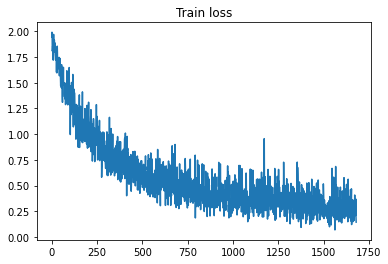

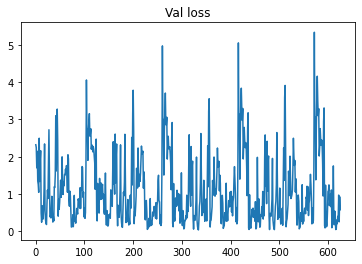

In [76]:
# TASK: plot loss --------------------------------------------------------------

plt.plot(model.train_loss)
plt.title('Train loss')
plt.show()

plt.plot(model.val_loss)
plt.title('Val loss')
plt.show()

# ------------------------------------------------------------------------------

#### Visualize Predictions

Similar to before, get a random sample from the test_dataset, run it through the model in evaluation mode to get a prediction, then visualize the image, the prediction and the ground truth. Get an example for every phase from the ground truth and look at the image and network prediction.

In [14]:
# TASK: visualize predition results --------------------------------------------

model = model.eval().cuda()

n = random.randint(0,len(test_dataset))
data = test_dataset[n]
image = data['image']

with torch.no_grad():
  y_hat = model.forward(image.unsqueeze(dim=0).cuda())
  y_hat = y_hat.argmax(dim=1)

print('predicted output',y_hat.cpu().numpy()[0])
print('Actual phase',phase)
# ------------------------------------------------------------------------------

predicted output 3
Actual phase 1


#### Visualize the predictions for a whole video

To see a complete predicted workflow we want to plot the predictions for a whole video as a sequence. To achieve that we first have to get the predictions for a whole video in sequence from the model and then plot them with the ground truth for comparison.

In [15]:
device = torch.device("cuda")
# TASK: set up the model for evaluation ----------------------------------------
# TIP: freeze the model, set to eval mode, transfer to gpu
model = model.eval().cuda()

# ------------------------------------------------------------------------------

video_name = "video06" # "video10" , "video42"
video_preds = []
video_labels = []
for batch in tqdm(test_loader):
  if batch['image_name'][0].startswith(video_name):
    with torch.no_grad():
      batch_preds = model.forward(batch['image'].cuda())
      # batch_preds = batch_preds.argmax(dim=1)

      # TASK: transfer the input to the gpu and evaluate with your model -------
      # batch_preds: Predictions of you model for the current batch


      # ------------------------------------------------------------------------
      for image_name, pred, label in zip(batch['image_name'], batch_preds, batch['phase']):
          if image_name.startswith(video_name):
            video_preds.append(pred.detach().cpu().numpy().argmax())
            video_labels.append(label.detach().cpu().numpy())

100%|██████████| 238/238 [00:24<00:00,  9.68it/s]


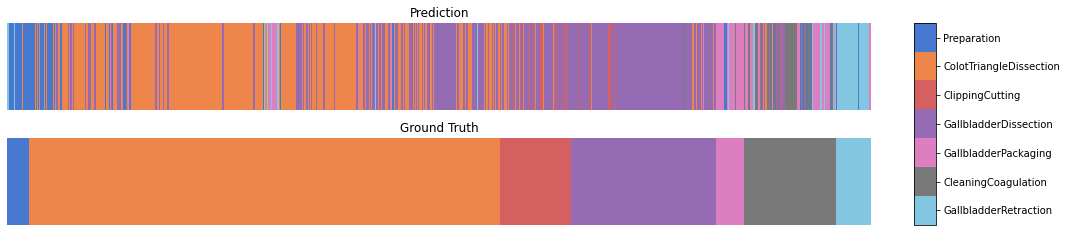

In [16]:
# Plot the predicted workflow
fig = plt.figure()
cmap= ListedColormap(sns.color_palette("muted", as_cmap=True))
levels= list(range(len(model.phase_names) + 1))
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

ax1 = fig.add_axes([0, 0.4, 2, 0.3])
barprops1 = dict(aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')
im1 = ax1.imshow(np.array(video_preds).reshape(1,-1), **barprops1)
ax1.set_axis_off()
ax1.set_title('Prediction')

ax2 = fig.add_axes([0, 0, 2, 0.3])
barprops2 = dict(aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')
im2 = ax2.imshow(np.array(video_labels).reshape(1,-1), **barprops2)
ax2.set_axis_off()
ax2.set_title('Ground Truth')

cbar_ax = fig.add_axes([2.1, 0, 0.05, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_ticks([x + 0.5 for x in range(7)])
cbar.set_ticklabels(model.phase_names)
cbar.ax.invert_yaxis()

## B. Workflow Recognition with Temporal Modelling

Recognizing the current phase of the surgery from a single image can be very difficult, even for a human expert. Including the temporal context in your phase prediction can be very helpful, so we will try to create a machine learning model that can do just that.

### B.1 Load the data as video clips with a phase label

For this exercise we want to include the temporal context in each prediction. We accomplish this by looking at the surgical videos contained in the dataset not as individual frames, but as short video clips.
Load the data so that you have sequences of 8 <b>consecutive</b> frames and the phase label of the last frame of each such sequence.

In [17]:
# load data
train_dataset_temp = LiverEndoscopy(split='train', balance_data=False, temporal=True)
val_dataset_temp = LiverEndoscopy(split='val', balance_data=False, temporal=True)
test_dataset_temp = LiverEndoscopy(split='test', balance_data=False, temporal=True)
train_loader_temp = DataLoader(train_dataset_temp, batch_size=32, shuffle=True, num_workers=2)
val_loader_temp = DataLoader(val_dataset_temp, batch_size=32, shuffle=False, num_workers=2)
test_loader_temp = DataLoader(test_dataset_temp, batch_size=32, shuffle=False, num_workers=2)

### B.2 Extract Image Features

We will use the model you previously trained as a feature extractor. This means, we will run every image in all the datasets through the model, and get the image features (not the phase predictions).
TASK: To this end, you first need to disable the linear layer of the model.
Make sure to set it  to evaluate model, transfer it to gpu, and freeze it as well.

Then we create a dictionary called all_features, where the keys will be the image names, and the values will be the corresponding image features.

In [49]:
# TASK: set model up to extract features ---------------------------------------
# TIP: freeze the model, set to eval mode, transfer to gpu and disable the linear layer

model = model.eval().cuda()

# ------------------------------------------------------------------------------

# recreate the train dataset without augmentions
train_dataset = LiverEndoscopy(split='train', balance_data=False, temporal=False, pil_transform=pil_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# TASK: iterate through the data, extract features with your model, write to all_features
# TIP: feature extraction should take 5 min to run
# TIP: extract features for all sets (train, val, test)
all_features = {} # Keys: image names, Features: corresponding image features

for loader in [train_loader,test_loader,val_loader]:

  for batch in tqdm(loader):
        # batch_preds = batch_preds.argmax(dim=1)

        # TASK: transfer the input to the gpu and evaluate with your model -------
        # batch_preds: Predictions of you model for the current batch

        with torch.no_grad():
          batch_preds = model.forward(batch['image'].cuda())

        # ------------------------------------------------------------------------
          for image_name, pred in zip(batch['image_name'], batch_preds):
            all_features[image_name]=pred

              # video_labels.append(label.detach().cpu().numpy())

  # ------------------------------------------------------------------------------


100%|██████████| 105/105 [00:42<00:00,  2.44it/s]

100%|██████████| 238/238 [00:25<00:00,  9.34it/s]

100%|██████████| 156/156 [00:15<00:00,  9.81it/s]


In [50]:
#Simple test for checking the validity of all features
assert all_features['video01_000276'].shape[0] == 512

### B.3 Simple Temporal model

Now you will design a temporal model, that will take the extracted image features as input and predict the surgical phase of the last frame in the sequence.

Many types of models can be used here. We will go for a very simple option. We will concatenate the image features from 8 neigbouring images, and feed it through 2 linear layers to make a final prediction of 7 phases again.

In [52]:
# build mlp
class TemporalModelWrapper(pl.LightningModule):
    def __init__(self, features):
        super().__init__()
        # TASK: Desfine you model layers ---------------------------------------
        # TIP: First layer: Input size: 512x8 -> output 256. 
        # TIP: Second Layer: Input size: 256 -> output 7
        
        self.firstlayer = nn.Linear(512*8,256)
        self.seclayer = nn.Linear(256,7)

        # ----------------------------------------------------------------------
        self.features = features

        self.train_preds = []
        self.train_gts = []
        self.val_preds = []
        self.val_gts = []
        self.test_preds = []
        self.test_gts = []
        self.reset_metrics()

        self.train_loss = []
        self.val_loss = []
        self.test_loss = []

        self.phase_names = ['Preparation', 'ColotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation',
                            'GallbladderRetraction']

    def forward(self, x):
        # TASK: define your network --------------------------------------------
        # TIP: x has the shape Batch_size x 8 x 512 -> You need to reshape it to batch_size x 4096 and then pass it through the fully connected layers
        
        x = x.flatten(start_dim = 1)
        x = self.firstlayer(x)
        x = self.seclayer(x)

        # ----------------------------------------------------------------------
        return x

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # We get the pre computed image features
        all_image_features = []
        for image_names in batch['image_names']:
            batch_image_features = [self.features[image_name.replace('.png', '')] for image_name in image_names]
            all_image_features.append(torch.stack(batch_image_features))
        all_image_features = torch.stack(all_image_features).transpose(0, 1)
        all_image_features = all_image_features.to(self.device)
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        y_hat = self.forward(all_image_features)
        loss = F.cross_entropy(y_hat,batch['phase'])

        # ----------------------------------------------------------------------
        self.update_metrics(batch['phase'], y_hat, split='train')
        self.train_loss.append(loss.item())
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        all_image_features = []
        for image_names in batch['image_names']:
            batch_image_features = [self.features[image_name.replace('.png', '')] for image_name in image_names]
            all_image_features.append(torch.stack(batch_image_features))
        all_image_features = torch.stack(all_image_features).transpose(0, 1)
        all_image_features = all_image_features.to(self.device)
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        y_hat = self.forward(all_image_features)
        loss = F.cross_entropy(y_hat,batch['phase'])

        # ----------------------------------------------------------------------
        self.update_metrics(batch['phase'], y_hat, split='val')
        self.val_loss.append(loss.item())
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        all_image_features = []
        for image_names in batch['image_names']:
            batch_image_features = [self.features[image_name.replace('.png', '')] for image_name in image_names]
            all_image_features.append(torch.stack(batch_image_features))
        all_image_features = torch.stack(all_image_features).transpose(0, 1)
        all_image_features = all_image_features.to(self.device)
        # TASK: get a prediction from the model and calculate cross_entropy loss.
        # y_hat: prediction from the model
        # loss: calculated loss from the model

        y_hat = self.forward(all_image_features)
        loss = F.cross_entropy(y_hat,batch['phase'])

        # ----------------------------------------------------------------------
        self.update_metrics(batch['phase'], y_hat, split='test')
        self.test_loss.append(loss.item())
        return {'test_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

    def reset_metrics(self, split=None):
        if split == 'train':
            self.train_preds = []
            self.train_gts = []
        elif split == 'val':
            self.val_preds = []
            self.val_gts = []
        elif split == 'test':
            self.test_preds = []
            self.test_gts = []
        else:
            self.train_preds = []
            self.train_gts = []
            self.val_preds = []
            self.val_gts = []
            self.test_preds = []
            self.test_gts = []

    def update_metrics(self, gt, pred, split='train'):
        if split == 'train':
            self.train_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.train_gts.extend(gt.detach().cpu().numpy())
        elif split == 'val':
            self.val_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.val_gts.extend(gt.detach().cpu().numpy())
        elif split == 'test':
            self.test_preds.extend(pred.detach().cpu().numpy().argmax(1))
            self.test_gts.extend(gt.detach().cpu().numpy())
        else:
            raise NotImplementedError()

    def training_epoch_end(self, outputs):
        self.evaluate_predictions(split='train')
        self.reset_metrics(split='train')

    def validation_epoch_end(self, outputs):
        self.evaluate_predictions(split='val')
        self.reset_metrics(split='val')

    def test_epoch_end(self, outputs):
        self.evaluate_predictions(split='test')
        self.reset_metrics(split='test')

    def evaluate_predictions(self, split):
        if split == 'train':
            preds = self.train_preds
            gts = self.train_gts
        elif split == 'val':
            preds = self.val_preds
            gts = self.val_gts
        elif split == 'test':
            preds = self.test_preds
            gts = self.test_gts
        else:
            raise NotImplementedError()

        cls_report = classification_report(gts, preds, labels=list(range(len(self.phase_names))),
                                           target_names=self.phase_names)
        print(split)
        print(cls_report)



#### Create and Train the Model

In [53]:
# TASK: create the temporal model and train it ---------------------------------
# TIP: again use pl.Trainer. Train for max_epochs=10 this time.
# temporal_model: your temporal model

temporal_model = TemporalModelWrapper(all_features)
# !mkdir '/content/lightning_logs'

trainer = pl.Trainer(gpus=1, 
                    # precision=16, 
                    # check_val_every_n_epoch=1,
                    log_every_n_steps=5,
                     max_epochs=10
                     )

# Train!
trainer.fit(model=temporal_model, train_dataloaders=train_loader_temp, val_dataloaders=val_loader_temp)

# ------------------------------------------------------------------------------

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | firstlayer | Linear | 1.0 M 
1 | seclayer   | Linear | 1.8 K 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.203     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.98      0.81      0.89        59
ColotTriangleDissection       0.00      0.00      0.00         5
        ClippingCutting       0.00      0.00      0.00         0
  GallbladderDissection       0.00      0.00      0.00         0
   GallbladderPackaging       0.00      0.00      0.00         0
    CleaningCoagulation       0.00      0.00      0.00         0
  GallbladderRetraction       0.00      0.00      0.00         0

              micro avg       0.75      0.75      0.75        64
              macro avg       0.14      0.12      0.13        64
           weighted avg       0.90      0.75      0.82        64



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.16      0.10      0.12       150
ColotTriangleDissection       0.87      0.57      0.69      1740
        ClippingCutting       0.35      0.41      0.38       305
  GallbladderDissection       0.60      0.96      0.73      1669
   GallbladderPackaging       0.44      0.47      0.45       251
    CleaningCoagulation       0.85      0.10      0.18       563
  GallbladderRetraction       0.54      0.68      0.61       264

               accuracy                           0.62      4942
              macro avg       0.54      0.47      0.45      4942
           weighted avg       0.68      0.62      0.59      4942

train
                         precision    recall  f1-score   support

            Preparation       0.83      0.66      0.74       701
ColotTriangleDissection       0.92      0.98      0.95      4247
        ClippingCutting       0.96      0.89      0.92      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.17      0.15      0.16       150
ColotTriangleDissection       0.85      0.61      0.71      1740
        ClippingCutting       0.33      0.44      0.38       305
  GallbladderDissection       0.64      0.93      0.76      1669
   GallbladderPackaging       0.39      0.57      0.46       251
    CleaningCoagulation       0.81      0.15      0.25       563
  GallbladderRetraction       0.60      0.64      0.62       264

               accuracy                           0.64      4942
              macro avg       0.54      0.50      0.48      4942
           weighted avg       0.69      0.64      0.62      4942

train
                         precision    recall  f1-score   support

            Preparation       0.95      0.89      0.92       701
ColotTriangleDissection       0.98      0.99      0.98      4247
        ClippingCutting       0.97      0.97      0.97      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.20      0.17      0.18       150
ColotTriangleDissection       0.84      0.64      0.73      1740
        ClippingCutting       0.34      0.41      0.37       305
  GallbladderDissection       0.64      0.93      0.76      1669
   GallbladderPackaging       0.40      0.47      0.44       251
    CleaningCoagulation       0.80      0.13      0.23       563
  GallbladderRetraction       0.58      0.66      0.62       264

               accuracy                           0.64      4942
              macro avg       0.54      0.49      0.47      4942
           weighted avg       0.68      0.64      0.62      4942

train
                         precision    recall  f1-score   support

            Preparation       0.96      0.92      0.94       701
ColotTriangleDissection       0.98      0.99      0.99      4247
        ClippingCutting       0.97      0.97      0.97      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.29      0.17      0.22       150
ColotTriangleDissection       0.87      0.59      0.70      1740
        ClippingCutting       0.43      0.34      0.38       305
  GallbladderDissection       0.57      0.96      0.72      1669
   GallbladderPackaging       0.41      0.47      0.44       251
    CleaningCoagulation       0.78      0.10      0.18       563
  GallbladderRetraction       0.63      0.65      0.64       264

               accuracy                           0.63      4942
              macro avg       0.57      0.47      0.47      4942
           weighted avg       0.68      0.63      0.60      4942

train
                         precision    recall  f1-score   support

            Preparation       0.95      0.94      0.95       701
ColotTriangleDissection       0.99      0.99      0.99      4247
        ClippingCutting       0.97      0.98      0.98      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.22      0.17      0.19       150
ColotTriangleDissection       0.88      0.59      0.70      1740
        ClippingCutting       0.38      0.39      0.39       305
  GallbladderDissection       0.61      0.95      0.74      1669
   GallbladderPackaging       0.40      0.50      0.45       251
    CleaningCoagulation       0.76      0.16      0.26       563
  GallbladderRetraction       0.56      0.66      0.61       264

               accuracy                           0.63      4942
              macro avg       0.54      0.49      0.48      4942
           weighted avg       0.68      0.63      0.61      4942

train
                         precision    recall  f1-score   support

            Preparation       0.96      0.95      0.95       701
ColotTriangleDissection       0.99      0.99      0.99      4247
        ClippingCutting       0.98      0.98      0.98      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.18      0.23      0.20       150
ColotTriangleDissection       0.89      0.56      0.69      1740
        ClippingCutting       0.34      0.40      0.37       305
  GallbladderDissection       0.60      0.94      0.74      1669
   GallbladderPackaging       0.40      0.51      0.45       251
    CleaningCoagulation       0.84      0.14      0.25       563
  GallbladderRetraction       0.64      0.65      0.64       264

               accuracy                           0.63      4942
              macro avg       0.56      0.49      0.48      4942
           weighted avg       0.69      0.63      0.61      4942

train
                         precision    recall  f1-score   support

            Preparation       0.97      0.96      0.97       701
ColotTriangleDissection       0.99      0.99      0.99      4247
        ClippingCutting       0.98      0.98      0.98      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.20      0.17      0.19       150
ColotTriangleDissection       0.86      0.61      0.71      1740
        ClippingCutting       0.41      0.35      0.38       305
  GallbladderDissection       0.60      0.95      0.73      1669
   GallbladderPackaging       0.40      0.53      0.45       251
    CleaningCoagulation       0.80      0.14      0.24       563
  GallbladderRetraction       0.68      0.64      0.66       264

               accuracy                           0.64      4942
              macro avg       0.56      0.48      0.48      4942
           weighted avg       0.68      0.64      0.61      4942

train
                         precision    recall  f1-score   support

            Preparation       0.97      0.97      0.97       701
ColotTriangleDissection       0.99      1.00      0.99      4247
        ClippingCutting       0.98      0.99      0.98      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.22      0.18      0.20       150
ColotTriangleDissection       0.86      0.60      0.71      1740
        ClippingCutting       0.34      0.41      0.37       305
  GallbladderDissection       0.61      0.95      0.74      1669
   GallbladderPackaging       0.43      0.47      0.44       251
    CleaningCoagulation       0.81      0.13      0.22       563
  GallbladderRetraction       0.64      0.66      0.65       264

               accuracy                           0.64      4942
              macro avg       0.56      0.49      0.48      4942
           weighted avg       0.68      0.64      0.61      4942

train
                         precision    recall  f1-score   support

            Preparation       0.97      0.97      0.97       701
ColotTriangleDissection       0.99      1.00      0.99      4247
        ClippingCutting       0.98      0.99      0.99      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.23      0.17      0.20       150
ColotTriangleDissection       0.84      0.63      0.72      1740
        ClippingCutting       0.35      0.38      0.37       305
  GallbladderDissection       0.61      0.95      0.74      1669
   GallbladderPackaging       0.43      0.46      0.44       251
    CleaningCoagulation       0.78      0.14      0.24       563
  GallbladderRetraction       0.70      0.64      0.67       264

               accuracy                           0.64      4942
              macro avg       0.56      0.48      0.48      4942
           weighted avg       0.68      0.64      0.62      4942

train
                         precision    recall  f1-score   support

            Preparation       0.98      0.97      0.98       701
ColotTriangleDissection       0.99      1.00      0.99      4247
        ClippingCutting       0.98      0.99      0.99      1639
  Gallbladd

Validation: 0it [00:00, ?it/s]

val
                         precision    recall  f1-score   support

            Preparation       0.25      0.16      0.20       150
ColotTriangleDissection       0.83      0.66      0.73      1740
        ClippingCutting       0.36      0.39      0.37       305
  GallbladderDissection       0.63      0.94      0.75      1669
   GallbladderPackaging       0.42      0.46      0.44       251
    CleaningCoagulation       0.79      0.14      0.24       563
  GallbladderRetraction       0.65      0.67      0.66       264

               accuracy                           0.65      4942
              macro avg       0.56      0.49      0.48      4942
           weighted avg       0.68      0.65      0.63      4942

train
                         precision    recall  f1-score   support

            Preparation       0.98      0.98      0.98       701
ColotTriangleDissection       0.99      1.00      0.99      4247
        ClippingCutting       0.99      0.99      0.99      1639
  Gallbladd

### B.4 Evaluate the results

#### Test the model

If everything worked correctly, you should observe an improved performance when using temporal modeling

In [55]:
# TASK: Test the model on the unseen test set ----------------------------------

trainer.test(temporal_model, dataloaders=test_loader_temp)

# ------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test
                         precision    recall  f1-score   support

            Preparation       0.82      0.47      0.60       236
ColotTriangleDissection       0.93      0.72      0.81      3620
        ClippingCutting       0.69      0.47      0.56       635
  GallbladderDissection       0.57      0.97      0.72      1903
   GallbladderPackaging       0.60      0.48      0.53       426
    CleaningCoagulation       0.51      0.29      0.37       414
  GallbladderRetraction       0.72      0.81      0.76       359

               accuracy                           0.72      7593
              macro avg       0.69      0.60      0.62      7593
           weighted avg       0.77      0.72      0.72      7593



[{}]

#### Plot the loss


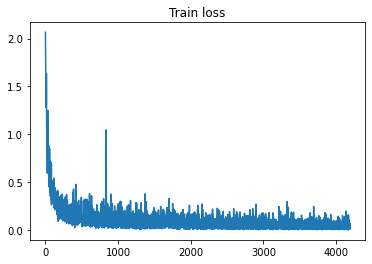

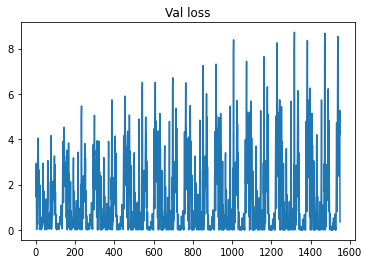

In [67]:
# TASK: plot loss --------------------------------------------------------------

plt.plot(temporal_model.train_loss)
plt.title('Train loss')
plt.show()

plt.plot(temporal_model.val_loss)
plt.title('Val loss')
plt.show()

# ------------------------------------------------------------------------------

#### Visualize the predictions for a whole video

To see a complete predicted workflow we want to plot the predictions for a whole video as a sequence like we did above. We can also plot the results from our normal model to compare against the temporal model.

In [57]:
device = torch.device("cuda")
# TASK: set up the temporal model for evaluation -------------------------------
# TIP: freeze the model, set to eval mode, transfer to gpu

temporal_model = temporal_model.eval().cuda()

# ------------------------------------------------------------------------------
video_name = "video06" # "video10" , "video42"
video_preds_temp = []
video_labels = []
for batch in tqdm(test_loader_temp):
  if batch['image_names'][0][-1].startswith(video_name):
    with torch.no_grad():
      # Get the pre computed image features
      batch_image_features = []
      for image_names in batch['image_names']:
          image_features = [temporal_model.features[image_name.replace('.png', '')] for image_name in image_names]
          batch_image_features.append(torch.stack(image_features))
      batch_image_features = torch.stack(batch_image_features).transpose(0, 1)
      # TASK: transfer the input to the gpu and evaluate with your model -------
      # batch_preds: Predictions of you model for the current batch

      batch_preds = temporal_model.forward(batch_image_features.cuda())


      # ------------------------------------------------------------------------
      for pred, label in zip(batch_preds, batch['phase']):
        video_preds_temp.append(pred.detach().cpu().numpy().argmax())
        video_labels.append(label.detach().cpu().numpy())


100%|██████████| 238/238 [00:00<00:00, 360.48it/s]


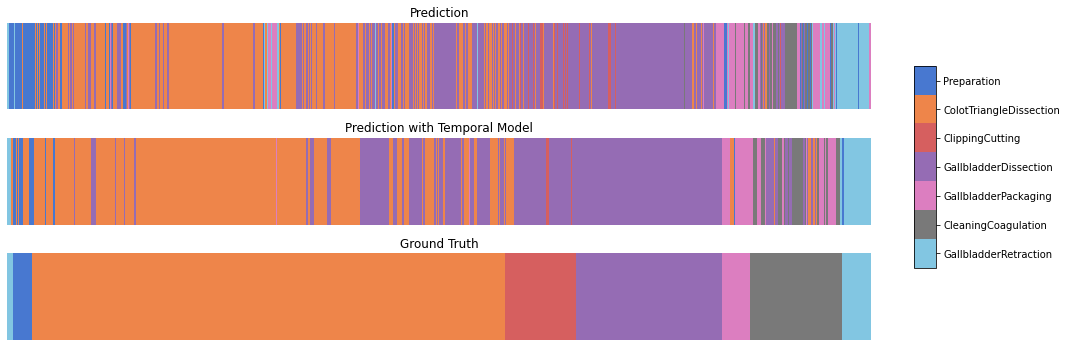

In [58]:
fig = plt.figure()
cmap= ListedColormap(sns.color_palette("muted", as_cmap=True))
levels= list(range(len(model.phase_names) + 1))
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
barprops = dict(aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')

ax1 = fig.add_axes([0, 0.8, 2, 0.3])
# predictions for the normal model are not computed again
im1 = ax1.imshow(np.array(video_preds).reshape(1,-1), **barprops)
ax1.set_axis_off()
ax1.set_title('Prediction')

ax2 = fig.add_axes([0, 0.4, 2, 0.3])
im2 = ax2.imshow(np.array(video_preds_temp).reshape(1,-1), **barprops)
ax2.set_axis_off()
ax2.set_title('Prediction with Temporal Model')

ax3 = fig.add_axes([0, 0, 2, 0.3])
im3 = ax3.imshow(np.array(video_labels).reshape(1,-1), **barprops)
ax3.set_axis_off()
ax3.set_title('Ground Truth')

cbar_ax = fig.add_axes([2.1, 0.25, 0.05, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_ticks([x + 0.5 for x in range(7)])
cbar.set_ticklabels(model.phase_names)
cbar.ax.invert_yaxis()

In [62]:
temporal_model.train_loss

[2.0670571327209473,
 1.959058165550232,
 1.8538862466812134,
 1.7825837135314941,
 1.671203374862671,
 1.6014689207077026,
 1.4614497423171997,
 1.4544036388397217,
 1.4168164730072021,
 1.597076654434204,
 1.281429409980774,
 1.3961373567581177,
 1.3185040950775146,
 1.3434135913848877,
 1.6347200870513916,
 1.2856810092926025,
 1.170660138130188,
 1.0800946950912476,
 1.1582305431365967,
 1.1621673107147217,
 1.149583339691162,
 1.1505602598190308,
 0.7552824020385742,
 1.0404616594314575,
 1.0687501430511475,
 0.6552402377128601,
 0.5957264304161072,
 0.9763520359992981,
 1.089540719985962,
 0.9842296838760376,
 0.9405805468559265,
 0.9230251908302307,
 1.2497773170471191,
 0.6866471767425537,
 0.9431208372116089,
 0.8428805470466614,
 0.8578406572341919,
 0.5920102000236511,
 0.8526793122291565,
 0.6349645853042603,
 0.7418839335441589,
 0.790969967842102,
 0.7718783020973206,
 0.7974498271942139,
 0.8845478892326355,
 0.7529214024543762,
 0.7488350868225098,
 0.7561356425285339,
